In this blog post, we explore some computationally simple systems with complex behaviours that I came across while reading James Gleick's excellent book [Chaos: Making a New Science](https://en.wikipedia.org/wiki/Chaos:_Making_a_New_Science).  

# The logistic map: a simple population model

The first system we'll compute is the [logistic map](https://en.wikipedia.org/wiki/Logistic_map). As described in the book, this system comes from a 1976 paper by the biologist Robert May and can be described as a discrete-time model for how a population grows. 

Given a population $x_n$, you can compute its next state $x_{n+1}$ with the following function:

In [1]:
def logistic_iter(x, r):
    "One iteration of the logistic map."
    return r * x - r * x**2

The above expression is made of two parts: $r x$ is analogous to a growth term as a function of previous population while $-r x^2$ can be described as a death rate when the population gets high. Critically, both are multiplied by $r$, which is a parameter of this model.

Let's build some understanding of this simple system by iterating it for 50 times, with a given start population between 0 and 1.

In [2]:
%matplotlib inline
from ipywidgets import interact, interactive, fixed
from matplotlib import pyplot as plt
import numpy as np

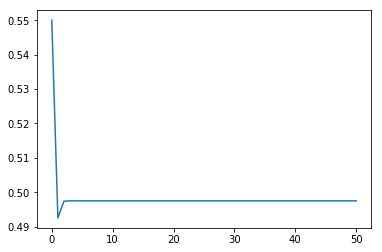

In [3]:
@interact
def plot_logistic_iterated(x0=(0.1, 1, 0.01), r=(0, 4, 0.01)):
    "Plots 50 iterations of a population, given the r parameter."
    vals = [x0]
    for _ in range(50):
        vals.append(logistic_iter(vals[-1], r))
    plt.plot(vals)

Interestingly, different things can happen. For low $r$ values, the population will just decrease:

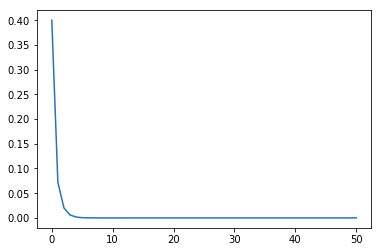

In [4]:
plot_logistic_iterated(x0=0.4, r=0.3)

For intermediate values, below 4, the population will reach equilibrium.

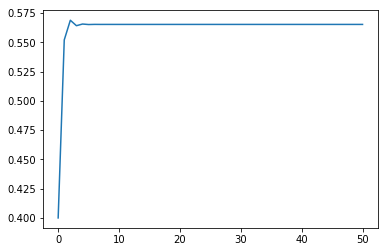

In [5]:
plot_logistic_iterated(x0=0.4, r=2.3)

And then for values closer but below 4, strange things happen:

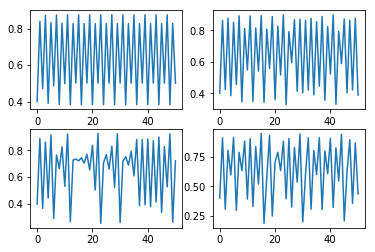

In [6]:
plt.subplot(2, 2, 1)
plot_logistic_iterated(x0=0.4, r=3.5)
plt.subplot(2, 2, 2)
plot_logistic_iterated(x0=0.4, r=3.6)
plt.subplot(2, 2, 3)
plot_logistic_iterated(x0=0.4, r=3.7)
plt.subplot(2, 2, 4)
plot_logistic_iterated(x0=0.4, r=3.8)

We can visualize this in another way, by showing the iterated values on a two dimensional graph:

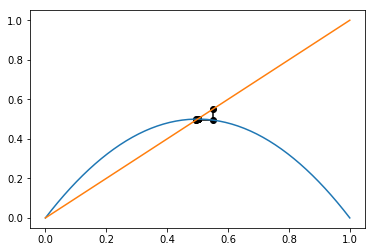

In [7]:
@interact
def plot_logistic_iterated_2D(x0=(0.1, 1, 0.01), r=(0.01, 4, 0.01), ax=fixed(None)):
    "Plots logistic map for 50 iterations on 2D plot."
    # computes iterated values
    vals = [x0]
    for _ in range(50):
        vals.append(logistic_iter(vals[-1], r))
    # plottingf
    if ax is None:
        fig, ax = plt.subplots()

    for x_start, x_end in zip(vals[:-1], vals[1:]):
        ax.plot([x_start, x_start, x_end], [x_start, x_end, x_end], '-ko')
    xx = np.linspace(0, 1)
    ax.plot(xx, logistic_iter(xx, r))
    ax.plot(xx, xx)

We can display what we observed before in this visualization:

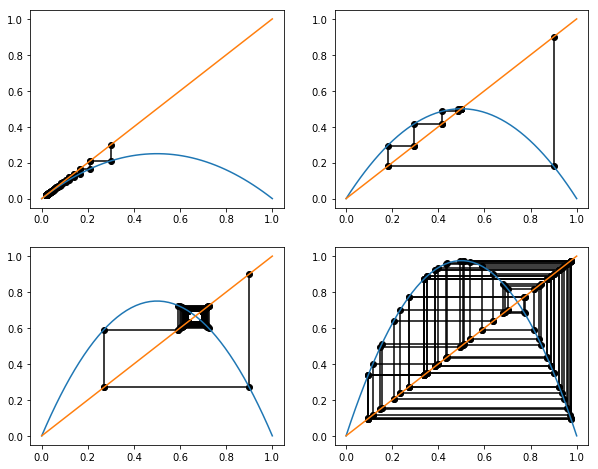

In [8]:
plt.figure(figsize=(10, 8))
ax = plt.subplot(2, 2, 1)
plot_logistic_iterated_2D(0.3, 1, ax=ax) # decrease to 0
ax = plt.subplot(2, 2, 2)
plot_logistic_iterated_2D(0.9, 2, ax=ax) # stable
ax = plt.subplot(2, 2, 3)
plot_logistic_iterated_2D(0.9, 3, ax=ax) # 2 cycle
ax = plt.subplot(2, 2, 4)
plot_logistic_iterated_2D(0.9, 3.9, ax=ax) # ? cycles

Finally, let's make an animation of this.

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

x = np.linspace(-2, 2, 200)

duration = 10

fig, ax = plt.subplots(dpi=100)
def make_frame(t):
    r = t / duration * 3.99
    ax.clear()
    plot_logistic_iterated_2D(0.3, r, ax=ax)
    return mplfig_to_npimage(fig)

animation = VideoClip(make_frame, duration=duration)
plt.close(fig)
animation.ipython_display(fps=25, loop=True, autoplay=True)

100%|███████████████████████████████████████▊| 250/251 [00:43<00:00,  5.71it/s]


Another way to plot this is to evaluate the final population after a fixed number of iterations over the two-dimensional grid in the $(r, x_0)$ space.

In [10]:
r = np.linspace(0, 4, num=400)
x0 = np.linspace(0, 1, num=400)
vals = np.empty((r.size, x0.size))
for i in range(vals.shape[0]):
    for j in range(vals.shape[1]):
        def final_value(x, r, iters=50):
            for _ in range(iters):
                x = logistic_iter(x, r)
            return x
        vals[i, j] = final_value(x0[j], r[i])

If we plot this with a marker at the final value of the population, we find a map with bifurcations, regions where it decreases to 0, where it reaches an equilibrium as a function of $r$, where it can have two values, more and more and then chaos.

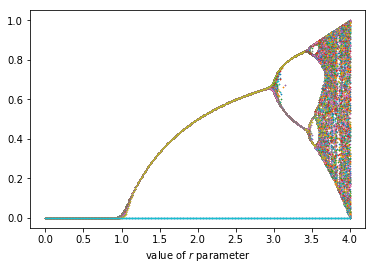

In [11]:
plt.plot([rr * np.ones(vals.shape[0]) for rr in r], [row for row in vals], 'x', ms=0.9)
plt.xlabel('value of $r$ parameter')

Finally, we can also plot this as an image over the 2D sampled space.

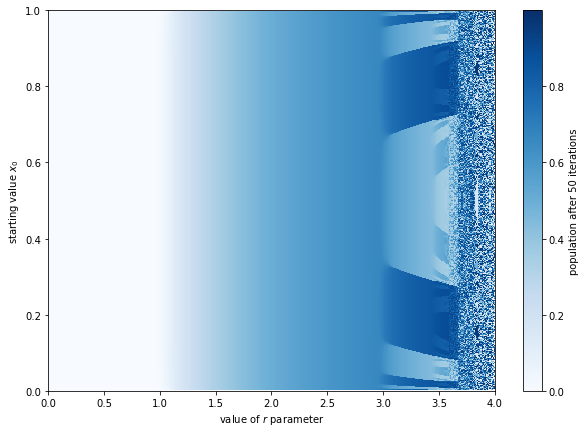

In [12]:
plt.figure(figsize=(10, 7))
plt.imshow(vals.T, extent=(r.min(), r.max(), x0.min(), x0.max()), origin='bottom', 
           aspect='auto', cmap='Blues')
plt.xlabel('value of $r$ parameter')
plt.ylabel('starting value $x_0$')
plt.colorbar(label='population after 50 iterations')

# Convergence of the Newton method in the complex plane

As a second example, we will turn to [Newton's method](https://en.wikipedia.org/wiki/Newton%27s_method) which, to quote the book, was "already old when Newton invented it". Newton's method is an iterative method that allows one to solve equations. If works by using the value of a function and its derivative to find a way to the functions zero.

One iteration of the method can be written as follows:

In [13]:
def newton_iter(z, func, func_prime):
    "One iteration of Newton's method."
    return z - func(z) / func_prime(z)

We will apply it to a fourth order polynomial in the complex plane $z \rightarrow z^4 - 1$. As the [fundamental theorem of Algebra](https://en.wikipedia.org/wiki/Fundamental_theorem_of_algebra) states, this polynomial has four roots, all on the unit circle. Using Newton's method starting anywhere in the complex plane, we should be able to find these four roots. 

First, let's see what this polynomial looks like.

In [14]:
def func(z):
    "Function to solve zeros for."
    return z**4 - 1

In [15]:
def func_prime(z):
    "Derivative of the above function."
    return 4 * z**3

In [16]:
def newton(func, func_prime, z, iters=25):
    "Apply Newton's method to a function and its derivative from point z."
    for _ in range(iters):
        z = newton_iter(z, func, func_prime)
    return z

In [17]:
from domain_coloring import plot_domain, contour_domaincol

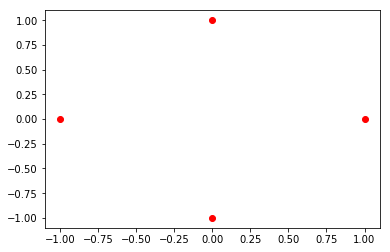

In [18]:
for i in range(4):
    z = np.exp(1j * np.pi / 2 * i)
    plt.plot(np.real(z), np.imag(z), 'ro')

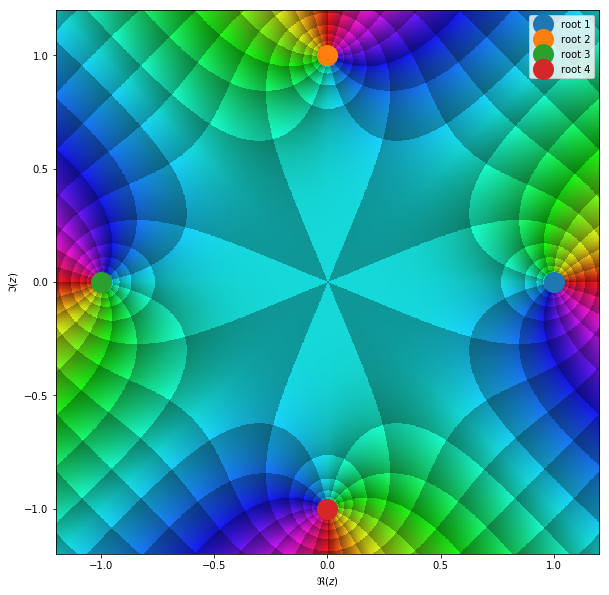

In [19]:
plt.figure(figsize=(10, 10))
plot_domain(contour_domaincol, func, re=[-1.2, 1.2], im=[-1.2, 1.2], N=400, daxis='x')
for i in range(4):
    z = np.exp(1j * np.pi / 2 * i)
    plt.plot(np.real(z), np.imag(z), 'o', ms=20, label='root {}'.format(i+1))
plt.legend()

Now, what is interesting is to look at which of these four roots we end up at, depending on where we start on the complex plane. We evaluate a grid of starting configurations below:

In [20]:
real = np.arange(-1.2, 1.2, 0.0011)
grid = real[:, np.newaxis] + 1j * real[np.newaxis, :]

roots = newton(func, func_prime, grid)

We can distinguish the four roots by plotting their phase, which will be either 0, $\pi /2$, $\pi$ or $3 \pi / 2$. 

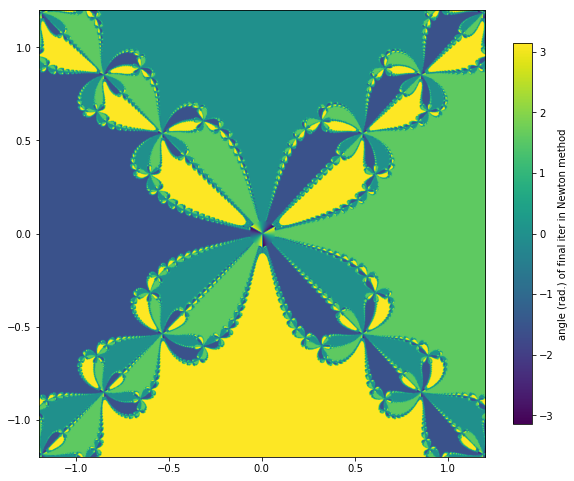

In [21]:
plt.figure(figsize=(10, 10))
plt.imshow(np.angle(roots), interpolation='bilinear', 
           extent=(real.min(), real.max(), real.min(), real.max()), origin='lower')
plt.colorbar(label='angle (rad.) of final iter in Newton method', shrink=0.7)

What this illustrates is that when you're close to a root, indeed you'll converge to this root. But the boundaries between the "stable" regions are incredibly complex, at different scales. 

We can compute a zoomed version of this image:

In [22]:
real = np.arange(-1.2, -0.001, 0.0011)
grid = real[:, np.newaxis] + 1j * real[np.newaxis, :]
roots = newton(func, func_prime, grid)

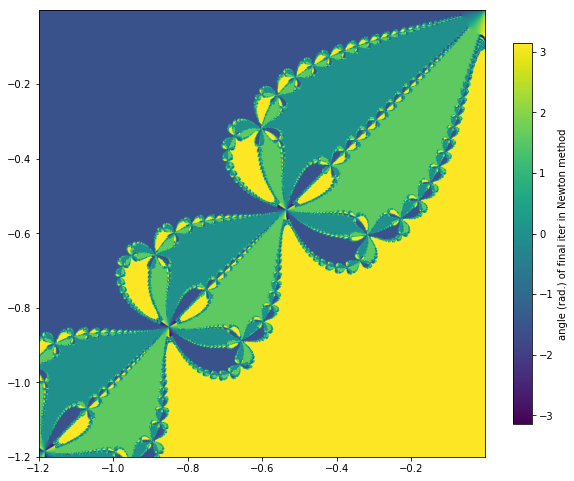

In [23]:
plt.figure(figsize=(10, 10))
plt.imshow(np.angle(roots), interpolation='bilinear', 
           extent=(real.min(), real.max(), real.min(), real.max()), origin='lower')
plt.colorbar(label='angle (rad.) of final iter in Newton method', shrink=0.7)

Indeed, not a simple boundary!

If you're interested in this sort of image, you can find whole galleries on the internet. For example here: http://aleph0.clarku.edu/~djoyce/newton/examples.html

# Lorenz system 

The final example of a complex system we will look at is the [Lorenz system](https://en.wikipedia.org/wiki/Lorenz_system).
Initially, this system appeared in what is a classic paper of Chaos theory: 

> Lorenz, Edward Norton (1963). "Deterministic nonperiodic flow". Journal of the Atmospheric Sciences. 20 (2): 130–141. doi:10.1175/1520-0469(1963)020<0130:DNF>2.0.CO;2.

It consists of three partial differential equations that can be seen as a simplified climate.
Inspired by [this](http://ipywidgets.readthedocs.io/en/latest/examples/Lorenz%20Differential%20Equations.html), we can build our own visualization of it. 

In [24]:
from IPython.display import clear_output, display, HTML
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation

In [25]:
def solve_lorenz(N=10, angle=0.0, max_time=4.0, xmax=1, zmax=2, ax=None, all_points=True):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_axes([0, 0, 1, 1], projection='3d')
    ax.axis('off')

    # prepare the axes limits
    ax.set_xlim((-xmax, xmax))
    ax.set_ylim((-xmax, xmax))
    ax.set_zlim((0, zmax))

    def lorenz_deriv(x_y_z, t0):
        """Compute the time-derivative of a Lorenz system."""
        x, y, z = x_y_z
        return [10 * (y - x), 
                -x * z + 28 * x - y, 
                x * y - 8./3 * z]

    # Choose random starting points, uniformly distributed from -15 to 15
    np.random.seed(1)
    x0 = 4 * np.random.random((N, 3)) + np.array([1, 1, 1])

    # Solve for the trajectories
    t = np.linspace(0, max_time, int(500*max_time))
    x_t = np.asarray([integrate.odeint(lorenz_deriv, x0i, t)
                      for x0i in x0])

    # choose a different color for each trajectory
    colors = plt.cm.viridis(np.linspace(0, 1, N))

    for i in range(N):
        x, y, z = x_t[i,:,:].T
        if all_points:
            lines = ax.plot(x, y, z, '-', c=colors[i])
        else:
            lines = ax.plot(x[-10:], y[-10:], z[-10:], c=colors[i])
        plt.setp(lines, linewidth=2)

    ax.view_init(30, angle)

    return t, x_t

Let's look at a couple of trajectories using this function:

In [26]:
max_times = [1, 3, 5, 7, 9, 12]

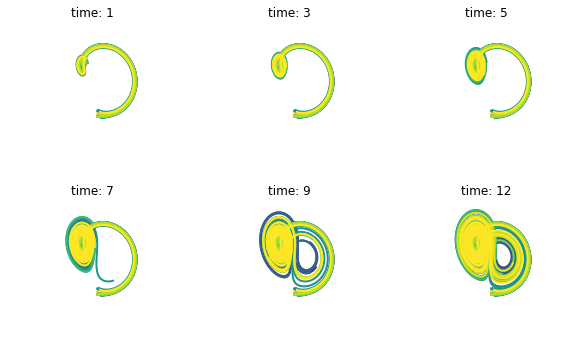

In [27]:
fig = plt.figure(figsize=(10, 6))
for ind, max_time in enumerate(max_times):
    ax = fig.add_subplot(2, 3, ind+1, projection='3d')
    t, x_t = solve_lorenz(angle=0, N=20, max_time=max_time, xmax=30, zmax=40, all_points=True, ax=ax)
    ax.set_title('time: {}'.format(max_time))

What is more interesting is to show this plot as a function of time, with particles (climate states in the analogy) close together initially.

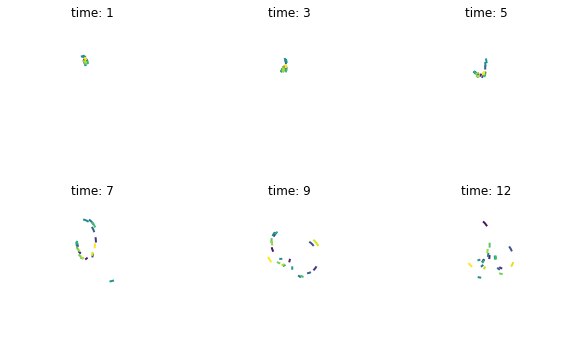

In [28]:
fig = plt.figure(figsize=(10, 6))
for ind, max_time in enumerate(max_times):
    ax = fig.add_subplot(2, 3, ind+1, projection='3d')
    t, x_t = solve_lorenz(angle=0, N=20, max_time=max_time, xmax=30, zmax=40, all_points=False, ax=ax)
    ax.set_title('time: {}'.format(max_time))

The key takeaway here is: even though the particles were initially close, the difference between them quickly explodes and by time 12, they are scattered through the state space with no noticeable structure or proximity between them. To quote Edward Lorenz:

> Chaos: When the present determines the future, but the approximate present does not approximately determine the future.

Here, the larger the time, the larger the breakdown of the "approximate prediction".

# Conclusions 

In this notebook, I tried to present three interesting problems about chaos theory or rather (to quote [Wikipedia](https://en.wikipedia.org/wiki/Chaos_theory)), systems that are highly sensitive to initial conditions. It's quite striking to think that these behaviours can be illustrated by computationally simple systems, but that they were hidden in plain sight until the 70's. Euler and Gauss did not know this existed, Laplace thought that with enough computing  power you could solve anything. Science has gone a long way since. 

*This post was entirely written using the IPython notebook. Its content is BSD-licensed. You can see a static view or download this notebook with the help of nbviewer at [20170523_ChaosExamples.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20170523_ChaosExamples.ipynb).*